# Using an Artificial Neural Network for the Task of Road Following

## Introduction

Autonomous driving is getting increased attention nowadays. While it was a pure research
topic in the 1980s, today there are many companies which develop self-driving cars. The algorithms
used by autonomous driving systems can vary widely from traditional vision and robotic techniques to
artificial neural networks. Since autonomous driving is a problem with a lot of noise and variability
in the input data it is hard to optimize traditional techniques to perform well. That is why
researcher developed artificial neural networks for the task of road following in the 1980s.
This work is based on the paper "ALVINN: An Autonomous Land Vehicle in a Neural Network" by
Pomerleau et al. and explores how a neural network can be used for the task of road following.
The neural network gets an image as input and outputs a steering wheel angle. This is called
an end-to-end steering system which should not be confused with semantic segmentation or object
detection frequently used by autonomous driving systems nowadays.


- Why is autonmous driving a hot topic right now?
- Difficulties with traditional algorithms
    - e.g. too much noise
- Introduction to vision based neural networks to predict a steering angle
- difference to semantic segmentation and object detection => this is an end to end driving system

## ALVINN Paper

- background information on the ALVINN project
- description of the technical details of the paper
- input:
    - camera
    - laser range finder
    - road intensity feedback unit
- output:
    - steering angle => as buckets
    - road intensity feedback unit
(use images from presentation)

- input preprocessing => using only one color channel
- sorting angles into buckets => encoding angles in a special way
- technical details about the test vehicle

## Implementation

- data set
    - real images
- differences to the paper
    - no laser range finder
    - road intensity feedback unit
    - just vision based
- framework (Tensorflow, OpenCV, Sklearn)

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

project_path = "/opt/project/"

import sys
sys.path.insert(0, project_path)

In [49]:
# load data set
import h5py

X = []
y = []
with h5py.File(f"{project_path}data/track_data_2.h5", "r") as f:
    for image, label in zip(f['images'], f['angles']):
        X.append(image)
        y.append(label)

X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.float32)

print(f"Data set size: {len(X)}")
print(f"Image size: {X[0].shape}")

Data set size: 2000
Image size: (60, 64)


In [3]:
# visualize the data set
from visualization import visualize_angle_in_gif

visualize_angle_in_gif(X, y, fn="training_data_visualization")

The following GIF shows the steering angle for each image displayed as
a green line.

![Training data visualization](graphic/training_data_visualization.gif)

In [4]:
# explore the data set

print(f"Images minimal pixel value: {X.min()}")
print(f"Images maximal pixel value: {X.max()}")
print()
print(f"Minimal steering angle: {y.min()}")
print(f"Maximal steering angle: {y.max()}")

Images minimal pixel value: 7.0
Images maximal pixel value: 255.0

Minimal steering angle: -165.42462158203125
Maximal steering angle: 23.003211975097656


## Data Set Preprocessing

Before the neural network can be trained, the input data has to be normalized.
This is done using Min-Max normalization with a minimum of 0.0 and a maximum
of 255.0.

Furthermore, each steering wheel angle has to be assigned to one of 45 bins.
This is not simply done by one-hot encoding the assigned bin but by encoding
the angle with the following values 0.1, 0.32, 0.61, 0.89, 1.0, 0.89, 0.61, 0.32, 0.1.
The target bin is the one with the 1.0 value and the ones left and right
get the other values.

Training data size: 1400


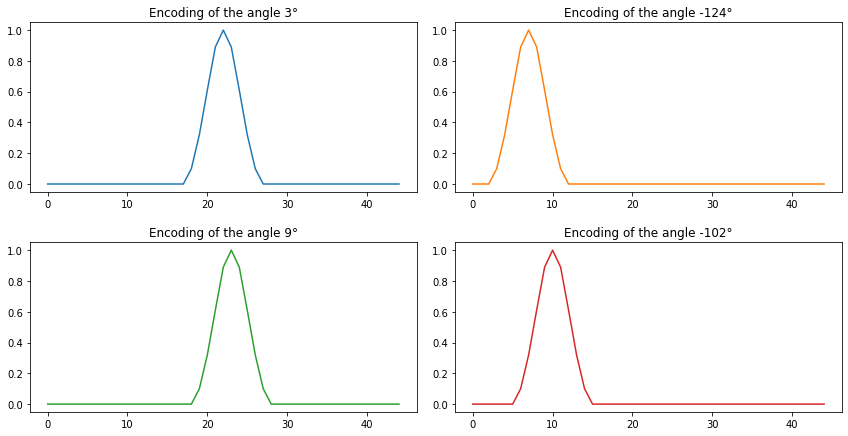

In [50]:
# data preprocessing
from sklearn.utils import shuffle

import utils

# normalize the images
X_normalized = X / 255.0

# encode the angles
y_encoded = utils.encode_angle(y, output_bins=45)

# visualize encoding
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.3, wspace=.1)
axs[0, 0].plot(y_encoded[0])
axs[0, 0].set_title(f"Encoding of the angle {round(y[0])}°")
axs[0, 1].plot(y_encoded[300], 'tab:orange')
axs[0, 1].set_title(f"Encoding of the angle {round(y[300])}°")
axs[1, 0].plot(y_encoded[50], 'tab:green')
axs[1, 0].set_title(f"Encoding of the angle {round(y[50])}°")
axs[1, 1].plot(y_encoded[1000], 'tab:red')
axs[1, 1].set_title(f"Encoding of the angle {round(y[1000])}°")

# split data into train (70%) and test data (30%)
train_data_size = round(len(X) * 0.7)
print(f"Training data size: {train_data_size}")

X_train = X_normalized[:train_data_size]
y_train = y_encoded[:train_data_size]

# shuffle data before training
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_test = X_normalized[train_data_size:]
y_test = y_encoded[train_data_size:]


In [6]:
# initialize tensorflow
import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
tf.random.set_seed(12)

# model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(60, 64)),
    tf.keras.layers.Dense(3840, activation=None),
    tf.keras.layers.Dense(29, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(45, activation=None)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.MeanSquaredError()
              )

Tensorflow version 2.5.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# train the neural network
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
44/44 [==============================] - 1s 3ms/step - loss: 0.0818
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0569
Epoch 8/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0548
Epoch 9/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0515
Epoch 10/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0490
Epoch 11/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0473
Epoch 12/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 13/100
44/44 [=================

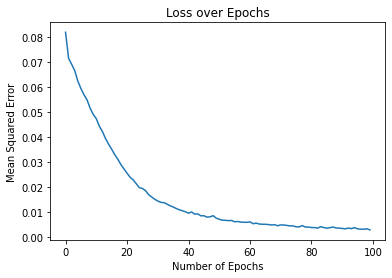

In [11]:
plt.plot(history.history["loss"])
plt.title("Loss over Epochs")
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of Epochs");

19/19 [==============================] - 0s 1ms/step - loss: 0.0101


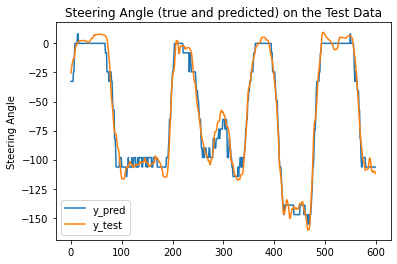

In [12]:
# testing and visualization
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

y_pred_degree = utils.decode_angle(y_pred, output_bins=45)
y_test_degree = y[train_data_size:]

plt.plot(y_pred_degree, label="y_pred")
plt.plot(y_test_degree, label="y_test")
plt.legend()
plt.title("Steering Angle (true and predicted) on the Test Data")
plt.ylabel("Steering Angle");

In [10]:
# visualize the performance in a video

visualize_angle_in_gif(X[train_data_size:], y_test_degree, y_pred_degree, "test_data_visualization")

![test data visualization](graphic/test_data_visualization.gif)

## Discussion

- strength
    - less susceptible to noise
    - easily assimilate multiple sensors
    - easy and fast to develop ones the data set is available => no parameter tuning
- weakness
    - if it is used in conditions that where not represented in the training data
    the network will perform poorly most likely
    - dealing with road forks

## Summary

- Neural networks are a powerfull tool for autonomous driving if they are trained with
 a sufficient amount of really data
- other network types could be tested => e.g. CNN in the NVIDIA Paper
